# Mode prediction -- multiple steps -- different features

Operator 2

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore

In [104]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 18})

## Processing functions

In [105]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [106]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': 
            curr_campaign = f['campaign'].iloc[i]

        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1:
            continue
    
        elif curr_campaign != f['campaign'].iloc[i]: 
            curr_campaign = f['campaign'].iloc[i]
        
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)

def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('Mode')
    
    X, y = series_split_sequences(train[features], train[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    X_test, y_test = series_split_sequences(test[features], test[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

    features.remove('campaign')

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, verbose=0)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred >= 0.5).astype(int)

    train_pred = model.predict(X, verbose=0)
    train_pred = (train_pred >= 0.5).astype(int)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_test, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred
    
    accuracy, recall, precision = metrics(y_pred=y_pred, y_true=y_test)
    train_accuracy, train_recall, train_precision = metrics(y_pred=train_pred, y_true=y)

    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(y_test[:, i], y_pred[:, i]))
        train_acc.append(accuracy_score(y[:, i], train_pred[:, i]))

    results = {'y_pred': y_pred,
               'y_true': y_test,
               'train_true': y,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }

    return results

def plot_mode(pred, true, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(np.array(pred), color=colors[1], label='Predicted', zorder=2)
    true = plt.plot(np.array(true) + 2, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.6))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nTraining features: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(handles=[pred[0], true[0]], ncols=2, loc='best')
    plt.tight_layout()
    plt.show()

    return fig

'''
    Plots the accuracy in a histogram for test and training data
'''
def plot_accuracy_timesteps(true, pred, train_true, train_pred, comb:list, n_steps_out:int, operator:str):
    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(true[:, i], pred[:, i]))
        train_acc.append(accuracy_score(train_true[:, i], train_pred[:, i]))
    
    print(acc)
    print(train_acc)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']
    x = np.arange(n_steps_out)

    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 6))

    bars1 = ax.bar(x - width/2, acc, width, label='Accuracy', color=mode_colors[2], edgecolor='white')

    bars2 = ax.bar(x + width/2, train_acc, width, label='Training Accuracy', color=mode_colors[3], edgecolor='white')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Step ahead')
    ax.set_title(f'{operator}\nAccuracy for each timestep ahead\nCombination of training features: {comb}')
    ax.set_xticks(x)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(labels[0:n_steps_out])
    ax.legend(loc='lower right')

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_value_labels(bars1)
    add_value_labels(bars2)

    plt.show()

    return fig


'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    sns.boxplot(data=np.array(accuracy).T, color=mode_colors[2], ax=axes[0], whis=whiskers, zorder=2)
    axes[0].set_title('Accuracy for test data')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Steps ahead')
    axes[0].set_xticklabels(labels[0:n_steps_out])
    axes[0].grid(zorder=0)

    sns.boxplot(data=np.array(accuracy_train).T, color=mode_colors[3], ax=axes[1], whis=whiskers, zorder=3)
    axes[1].set_title('Accuracy for train data')
    axes[1].set_ylabel('Training Accuracy')
    axes[1].set_xlabel('Steps ahead')
    axes[1].set_xticklabels(labels[0:n_steps_out])
    axes[1].grid(zorder=0)

    plt.tight_layout()
    plt.show()

    return fig

In [107]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op2_merged.csv'
operator = 'Operator 2'

In [108]:
op2_overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
               'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
               'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

test = read_dataset(dataset, campaigns=[op2_overlap[0]])
train = read_dataset(dataset, campaigns=op2_overlap[1:3])
test_campaigns = test['campaign'].unique().tolist()

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[op2_overlap[3]])
test = pd.concat([route_to_add[5350::], test])
test.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [109]:
target_features = ['Mode']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

## 1 step ahead

In [110]:
# parameters
n_steps_in = 2
n_steps_out = 1
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.452,0.992,0.088,0.526,0.845,0.044
1,SINR,0.533,0.620,0.577,0.619,0.580,0.821
2,RSRQ,0.528,0.596,0.668,0.511,0.502,0.749
3,"RSRP, SINR",0.452,0.567,0.373,0.669,0.671,0.642
4,"RSRP, RSRQ",0.601,0.601,1.000,0.492,0.492,1.000
5,"SINR, RSRQ",0.493,0.591,0.507,0.645,0.603,0.811
6,"RSRP, SINR, RSRQ",0.506,0.597,0.548,0.644,0.602,0.811
7,SSS_RSRP,0.399,0.000,0.000,0.508,0.000,0.000
8,SSS_SINR,0.645,0.815,0.529,0.801,0.844,0.731
9,SSS_RSRQ,0.565,0.797,0.370,0.747,0.879,0.562


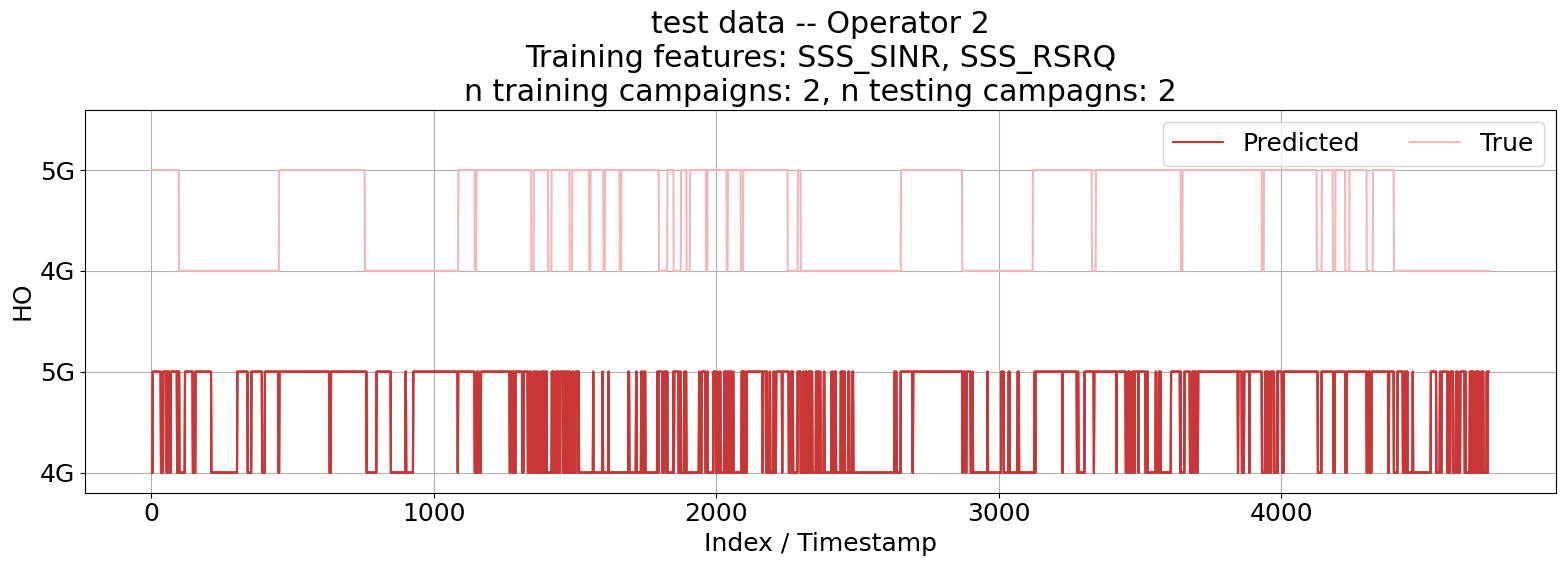

In [111]:

combination = 'SSS_SINR, SSS_RSRQ'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_sss_sinr_rsrq.pdf')

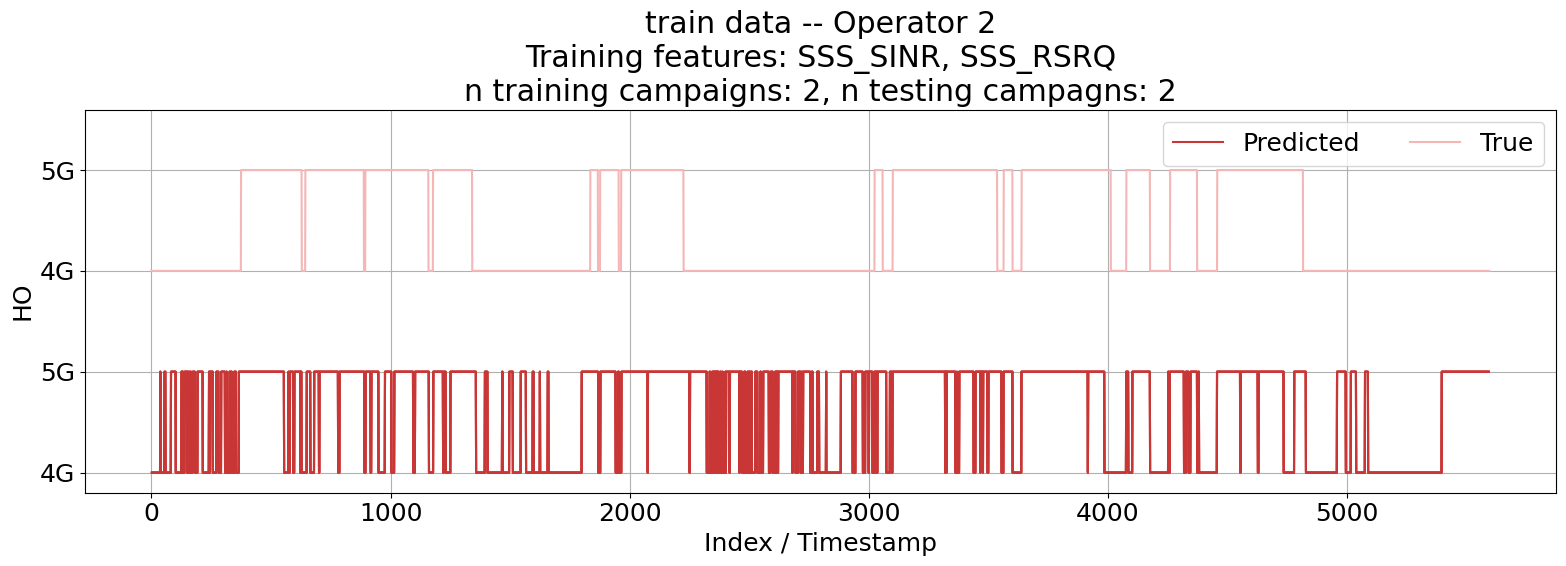

In [112]:
fig = plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_sss_sinr_rsrq_train.pdf')

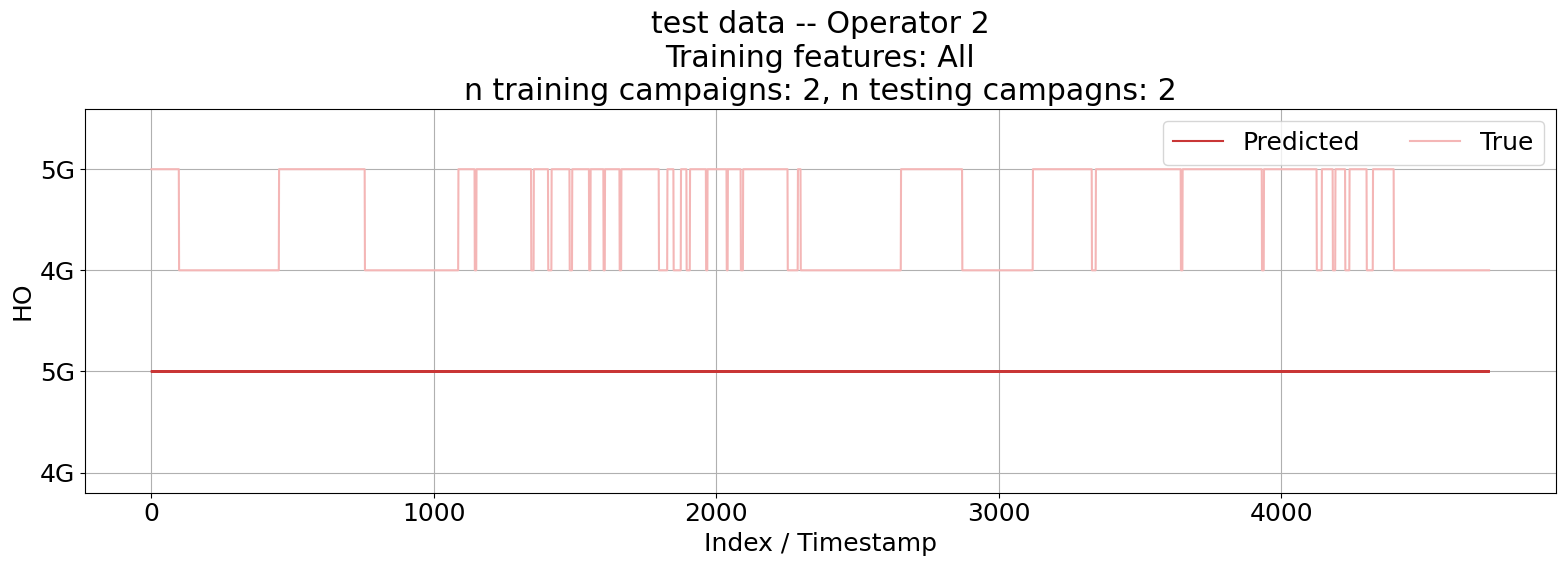

In [113]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_all_param.pdf')

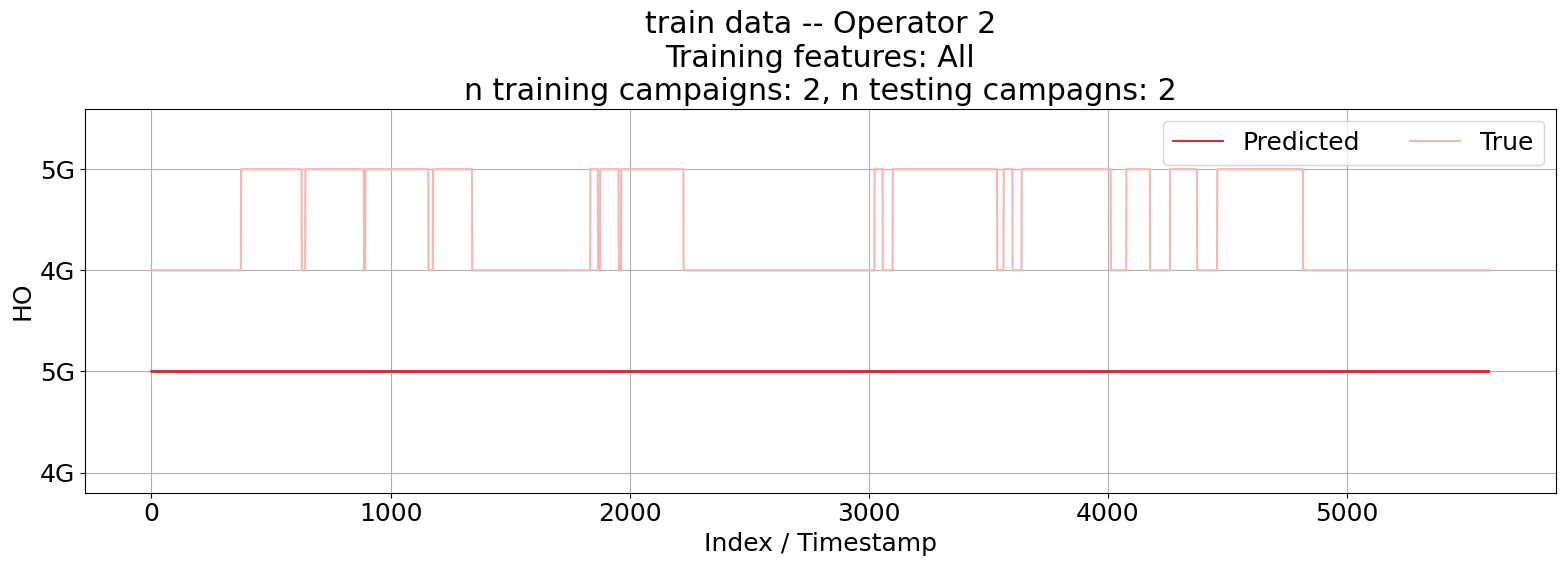

In [114]:
fig = plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/mode_pred/op2_plot_all_param_train.pdf')

## 2 steps ahead

In [115]:
# parameters
n_steps_in = 2
n_steps_out = 2
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.401,1.000,0.002,0.508,0.000,0.000
1,SINR,0.509,0.607,0.519,0.643,0.603,0.803
2,RSRQ,0.529,0.595,0.679,0.509,0.501,0.774
3,"RSRP, SINR",0.456,0.699,0.166,0.584,0.780,0.215
4,"RSRP, RSRQ",0.516,0.583,0.679,0.598,0.572,0.726
5,"SINR, RSRQ",0.466,0.573,0.435,0.686,0.650,0.784
6,"RSRP, SINR, RSRQ",0.601,0.601,1.000,0.493,0.493,1.000
7,SSS_RSRP,0.686,0.822,0.608,0.720,0.732,0.679
8,SSS_SINR,0.646,0.812,0.534,0.791,0.823,0.732
9,SSS_RSRQ,0.570,0.797,0.382,0.743,0.858,0.571


Number of predicted 5G point: 2959
Number of true 5G points: 5684

[0.6385542168674698, 0.6341154090044389]
[0.8135957066189624, 0.8094812164579607]


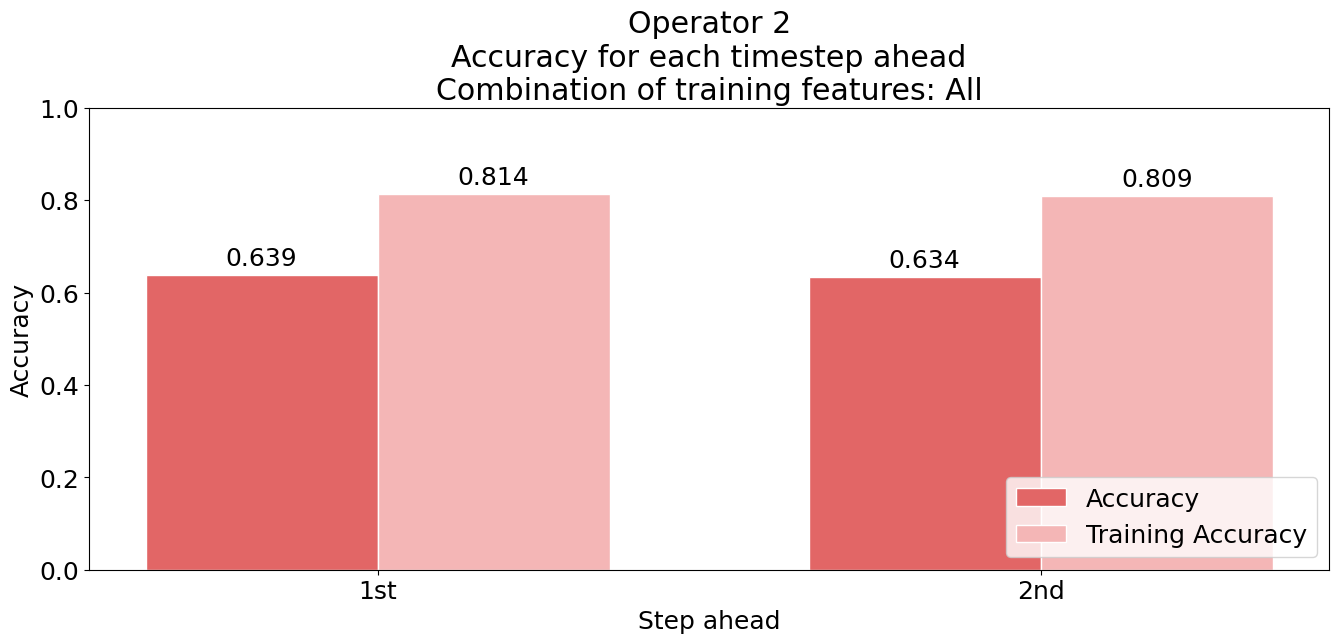

In [116]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_2_steps.pdf')

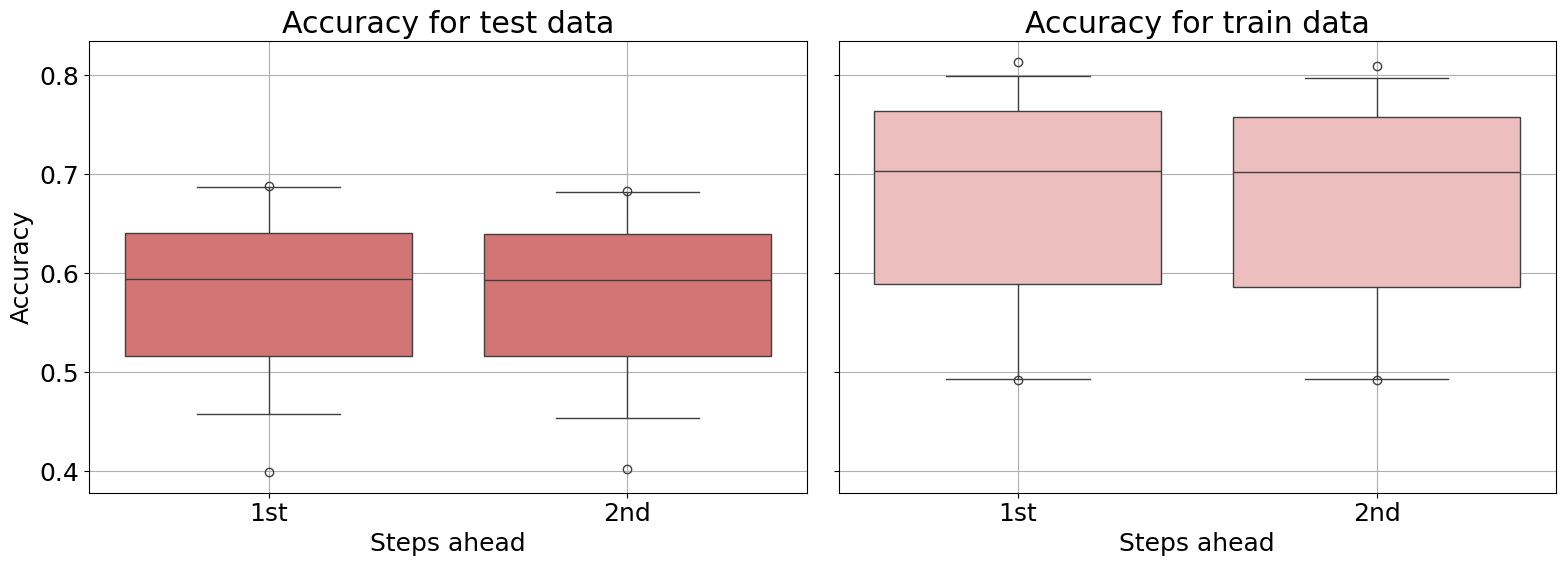

In [117]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_2_steps.pdf')

## 3 steps ahead

In [118]:
# parameters
n_steps_in = 3
n_steps_out = 3
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.572,0.610,0.796,0.547,0.525,0.837
1,SINR,0.517,0.618,0.515,0.646,0.606,0.805
2,RSRQ,0.535,0.586,0.767,0.506,0.499,0.862
3,"RSRP, SINR",0.517,0.609,0.546,0.632,0.594,0.803
4,"RSRP, RSRQ",0.601,0.601,1.000,0.492,0.492,1.000
5,"SINR, RSRQ",0.533,0.606,0.638,0.645,0.595,0.877
6,"RSRP, SINR, RSRQ",0.519,0.588,0.667,0.632,0.590,0.829
7,SSS_RSRP,0.601,0.601,1.000,0.492,0.492,1.000
8,SSS_SINR,0.655,0.813,0.552,0.786,0.807,0.742
9,SSS_RSRQ,0.580,0.792,0.408,0.736,0.814,0.600


Number of predicted 5G point: 6186
Number of true 5G points: 8517

[0.6953670404061773, 0.6913475777448699, 0.6924053310767929]
[0.8390619405656999, 0.8313641245972073, 0.8254564983888292]


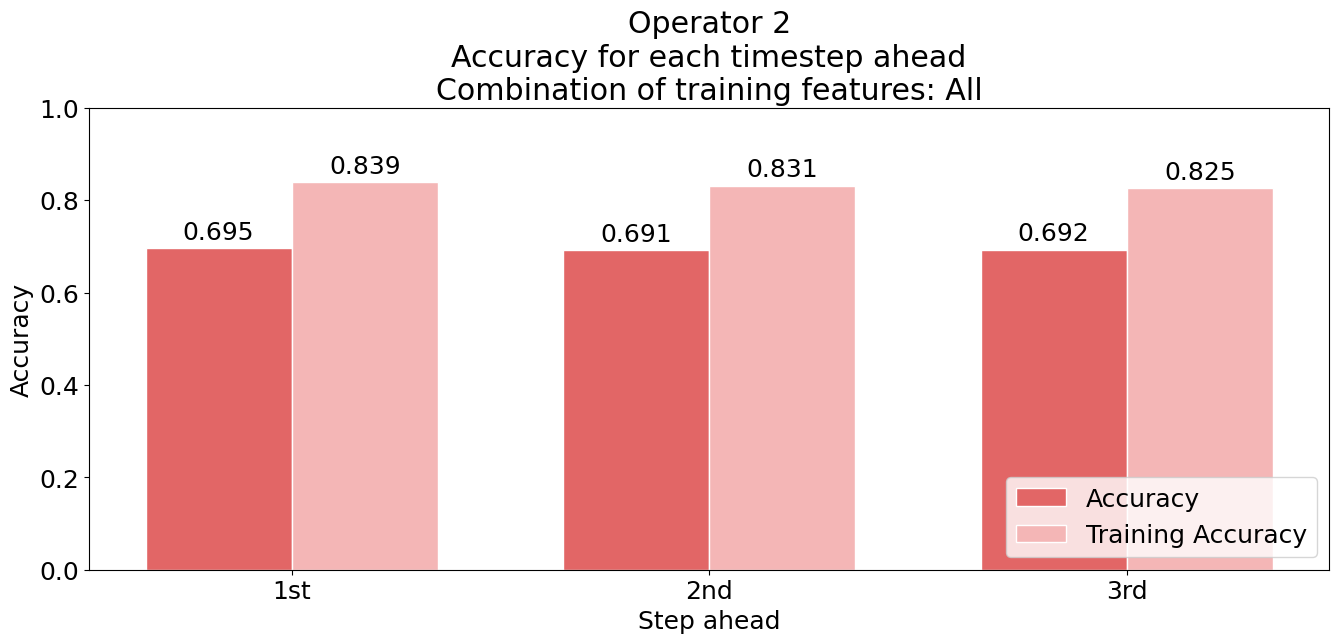

In [119]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_3_steps.pdf')

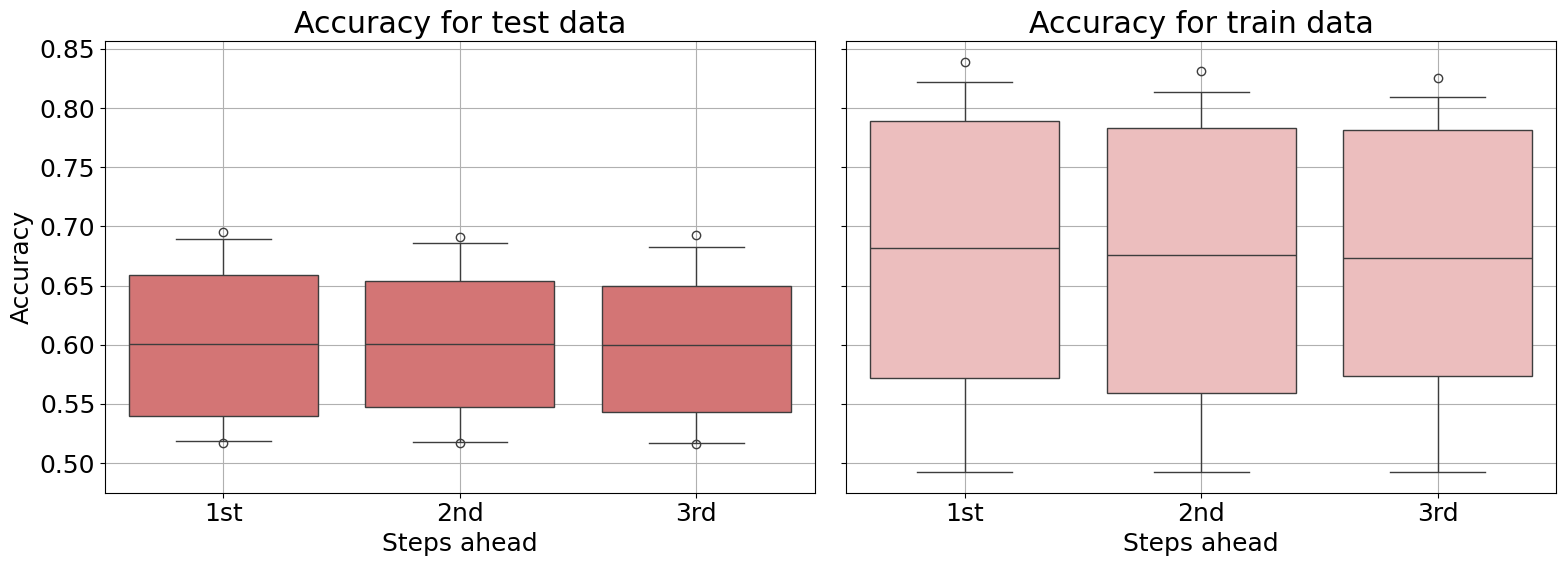

In [120]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_3_steps.pdf')

## 5 steps ahead

In [121]:
# parameters
n_steps_in = 5
n_steps_out = 5
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.600,0.600,1.000,0.493,0.493,1.000
1,SINR,0.450,0.572,0.334,0.641,0.636,0.637
2,RSRQ,0.583,0.595,0.956,0.514,0.503,0.985
3,"RSRP, SINR",0.495,0.563,0.709,0.525,0.511,0.866
4,"RSRP, RSRQ",0.581,0.615,0.810,0.546,0.526,0.785
5,"SINR, RSRQ",0.526,0.599,0.635,0.665,0.604,0.934
6,"RSRP, SINR, RSRQ",0.600,0.600,1.000,0.493,0.493,1.000
7,SSS_RSRP,0.600,0.600,1.000,0.493,0.493,1.000
8,SSS_SINR,0.631,0.788,0.527,0.798,0.818,0.759
9,SSS_RSRQ,0.578,0.786,0.408,0.734,0.814,0.596


Number of predicted 5G point: 23595
Number of true 5G points: 14165

[0.601186692095783, 0.6007628734901462, 0.6003390548845094, 0.5999152362788727, 0.5994914176732359]
[0.49300824668339904, 0.49300824668339904, 0.49300824668339904, 0.49300824668339904, 0.49300824668339904]


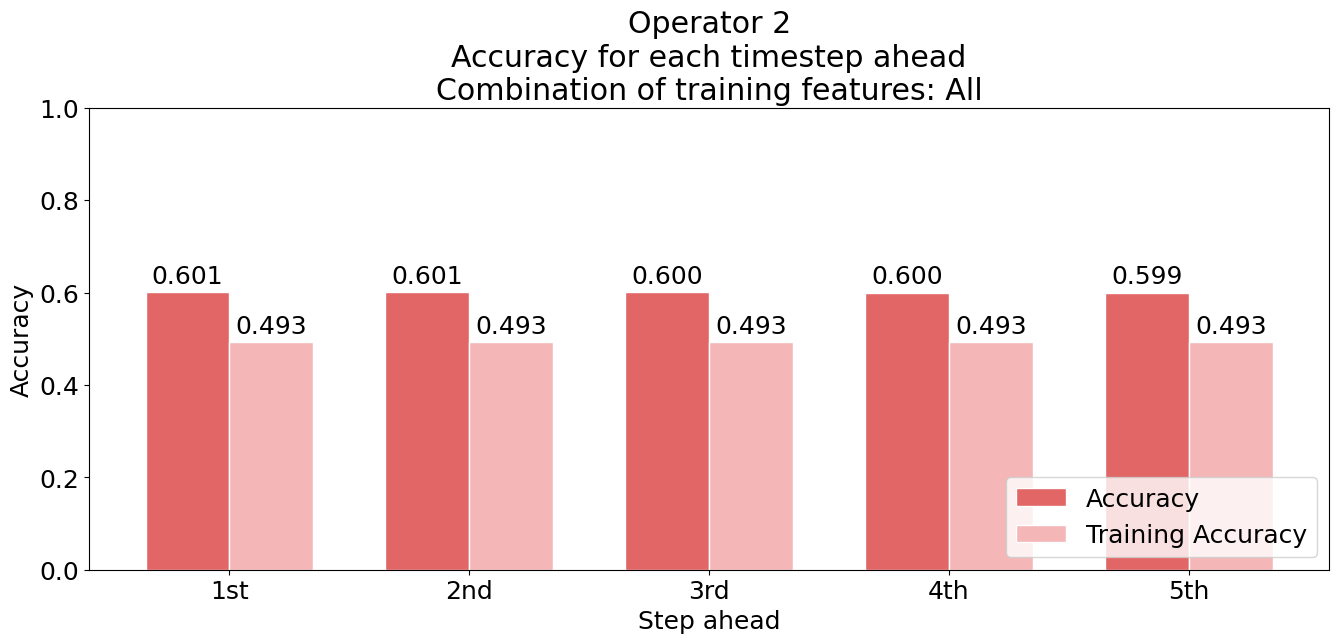

In [122]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_5_steps.pdf')

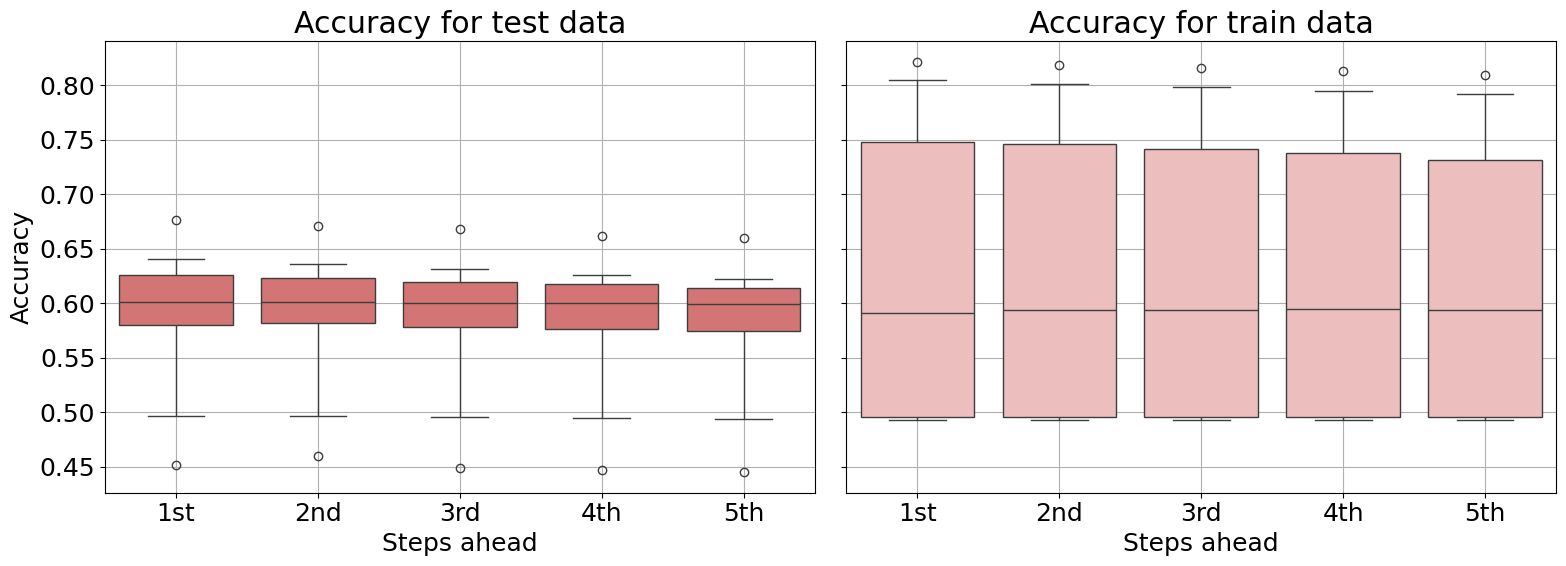

In [123]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_5_steps.pdf')

## 10 steps ahead

In [124]:
# parameters
n_steps_in = 8
n_steps_out = 10
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.600,0.744,0.559,0.538,0.767
1,SINR,0.460,0.583,0.353,0.665,0.645,0.718
2,RSRQ,0.591,0.598,0.968,0.528,0.512,0.975
3,"RSRP, SINR",0.530,0.613,0.587,0.644,0.604,0.812
4,"RSRP, RSRQ",0.550,0.604,0.723,0.610,0.584,0.739
5,"SINR, RSRQ",0.478,0.582,0.461,0.710,0.664,0.839
6,"RSRP, SINR, RSRQ",0.485,0.572,0.565,0.629,0.592,0.803
7,SSS_RSRP,0.400,0.000,0.000,0.506,0.000,0.000
8,SSS_SINR,0.629,0.770,0.545,0.792,0.796,0.778
9,SSS_RSRQ,0.625,0.757,0.552,0.714,0.704,0.729


Number of predicted 5G point: 15479
Number of true 5G points: 28220

[0.6536253455241335, 0.6487348500956837, 0.6457580267914097, 0.6449075058473315, 0.6381033382947056, 0.6347012545183925, 0.6300233893259621, 0.6274718264937275, 0.6219434403572188, 0.6240697427174144]
[0.790722761596548, 0.7873067241999281, 0.7838906868033082, 0.7826321467098166, 0.777418194893923, 0.7743617403811579, 0.7711254944264653, 0.7662711254944264, 0.765551959726717, 0.7626752966558792]


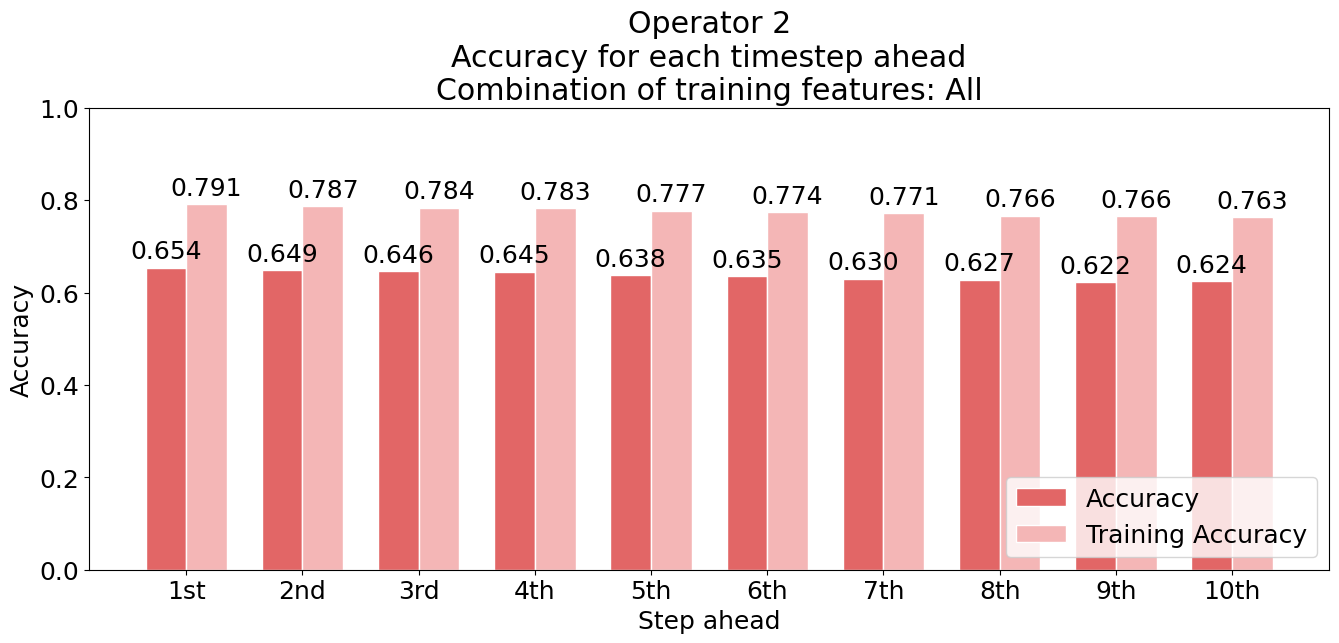

In [125]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}\nNumber of true 5G points: {np.sum(true)}\n')

fig = plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)
fig.savefig(r'../latex/plots/mode_pred/op2_hist_10_steps.pdf')

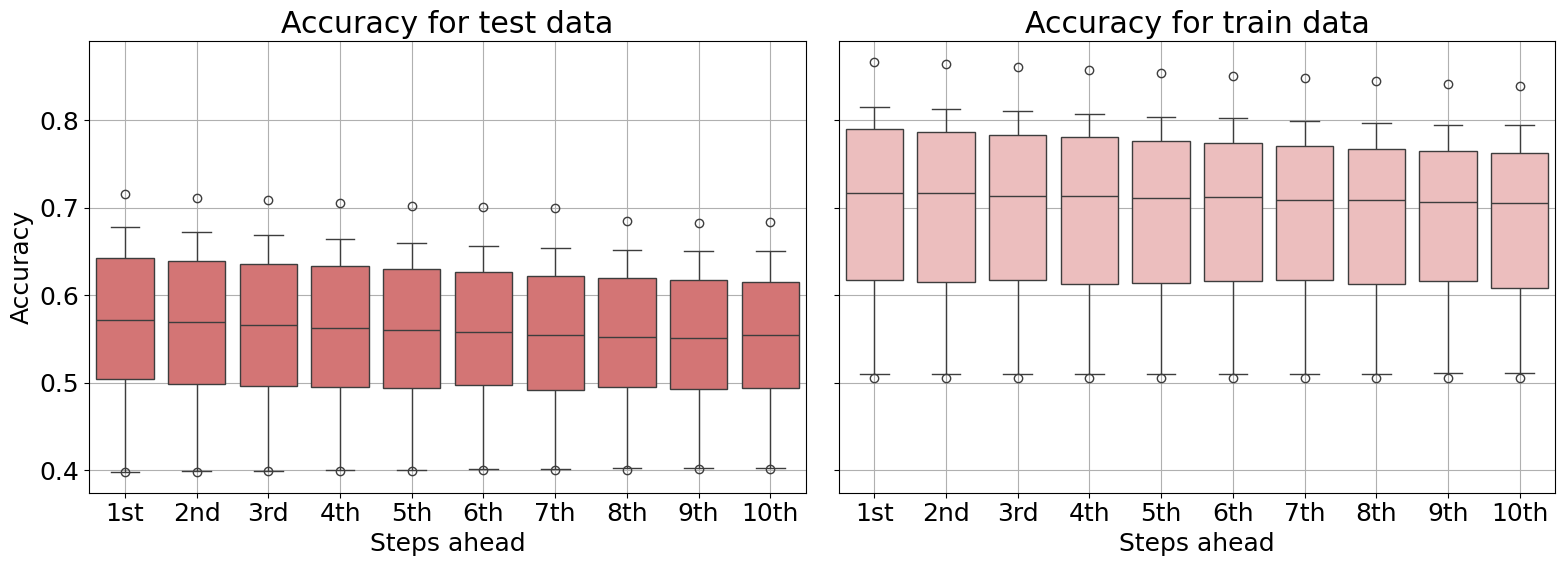

In [126]:
fig = boxplot_accuracies(results=results, n_steps_out=n_steps_out)
fig.savefig(r'../latex/plots/mode_pred/op2_boxplot_10_steps.pdf')